In [76]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

In [77]:
def output_label(output):
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")
    # Read the categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    return top5_catid[0]

def transform_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)
    return out

In [78]:
# img = Image.open("pug.jpeg")
images = ["i1.jpg", "i2.jpg", "i3.jpg", "i4.jpg", "i5.jpg"]
input_images = []
for img in images:
  preprocess = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
  img = Image.open(img)
  img = preprocess(img)
  img.unsqueeze_(0)
  img.requires_grad = True
  input_images.append(img)


In [79]:
res_model = torchvision.models.resnet50(True)
res_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

1a) vanilla backpropogation

In [80]:
outputs = []

for img in input_images:
  output = res_model(img)
  predicted_id = output_label(output)

  output[0, predicted_id].backward()
  grads = img.grad

  grads_norm = transform_output(grads)
  print(grads_norm.shape)
  grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
  grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
  outputs.append(grads_norm)
  # plt.imshow(grads_norm)

German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197
(224, 224, 3)
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755
(224, 224, 3)
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946
(224, 224, 3)
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627
(224, 224, 3)
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351
(224, 224, 3)


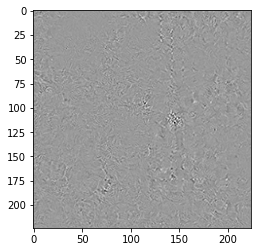

In [81]:
plt.imshow(outputs[0], cmap="gray")

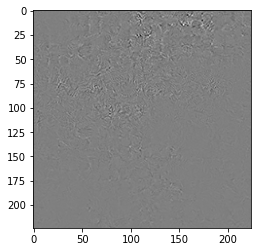

In [82]:
plt.imshow(outputs[1], cmap="gray")

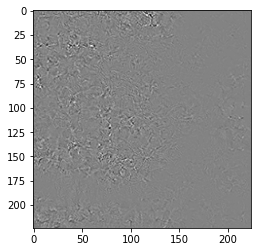

In [83]:
plt.imshow(outputs[2], cmap="gray")

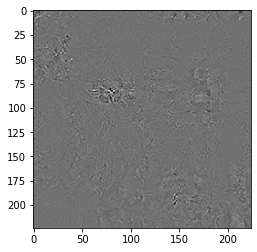

In [84]:
plt.imshow(outputs[3], cmap="gray")

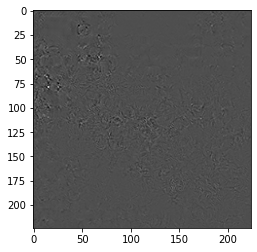

In [85]:
plt.imshow(outputs[4], cmap="gray")

1b) Guided backpropogation

In [86]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

for module in res_model.modules():
    module.register_backward_hook(relu_hook_function)

 

In [87]:
outputs = []
for img in input_images:
  output = res_model(img)
  predicted_id = output_label(output)

  output[0, predicted_id].backward()
  grads = img.grad
  grads_norm = transform_output(grads)
  print(grads_norm.shape)
  grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
  grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
  outputs.append(grads_norm)
  # plt.imshow(grads_norm)

German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197
(224, 224, 3)
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755
(224, 224, 3)
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946
(224, 224, 3)
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627
(224, 224, 3)
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351
(224, 224, 3)


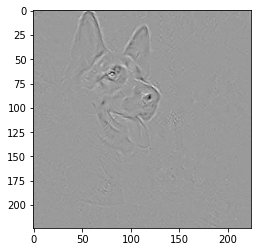

In [88]:
plt.imshow(outputs[0], cmap="gray")

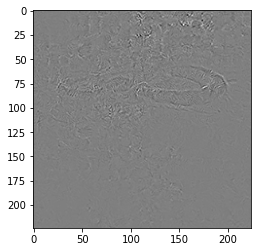

In [89]:
plt.imshow(outputs[1], cmap="gray")

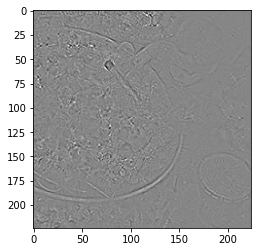

In [90]:
plt.imshow(outputs[2], cmap="gray")

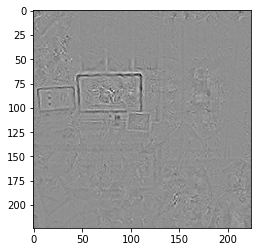

In [91]:
plt.imshow(outputs[3], cmap="gray")

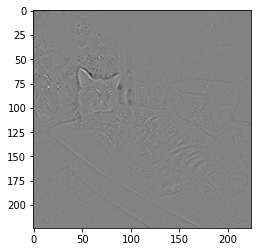

In [92]:
plt.imshow(outputs[4], cmap="gray")

1c) gradCAM

In [93]:
res_model = torchvision.models.resnet50(pretrained=True)
res_model.eval()

img.requires_grad = True
global gradients
gradients = None
target_layer = 11
global activations
activations = None

def save_gradient(module, inp, out):
  global gradients
  gradients = out

def save_conv_output(module, inp, out):
  global activations
  activations = out

for i, module in enumerate(res_model.modules()):
  if(i == target_layer):
    module.register_backward_hook(save_gradient)
    module.register_forward_hook(save_conv_output)
# def save_conv_output(module, inp, out):
#   activations = out

def forward_pass(input_image, target_layer):
  x = input_image
  output = res_model(x)
  predictions = torch.softmax(output, dim=1)

  return activations, output

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [94]:
def CAM(input_image, target_layer):
  target_layer_conv_output, final_output = forward_pass(input_image, target_layer)
  predictions = torch.softmax(final_output, dim=1)
  top_predictions, top_indices = torch.topk(predictions, k=5)
  index = top_indices[0][0]

  one_hot_output = torch.FloatTensor(1, final_output.size()[-1]).zero_()
  one_hot_output[0][index] = 1

  final_output.backward(gradient = one_hot_output, retain_graph = True)
  # print(gradients)
  grads = gradients[0].data.numpy()[0]

  weights = np.mean(grads, axis = (1, 2))
  target = activations.data.numpy()[0]
  cam = np.ones(target.shape[1:], dtype=np.float32)
  for i in range(weights.shape[0]):
      cam+=weights[i]*target[i,:,:]
  cam = np.maximum(cam, 0)
  cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
  cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
  cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],input_image.shape[3]), Image.ANTIALIAS))/255
  cam1 = np.zeros((224,224,3))
  cam1[:,:,0]= cam
  cam1[:,:,1]= cam
  cam1[:,:,2]= cam
  return cam

In [95]:
# img = plt.imread("pug.jpeg")
output_images = []
for img in input_images:
  output_images.append(CAM(img, 11))

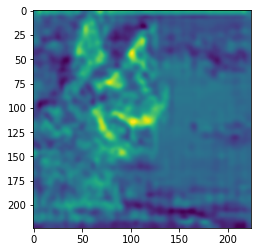

In [96]:
plt.imshow((output_images[0]*255).astype(np.uint32))

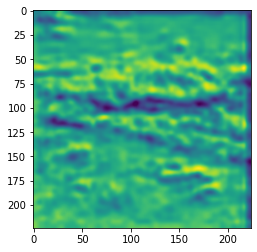

In [97]:
plt.imshow((output_images[1]*255).astype(np.uint32))

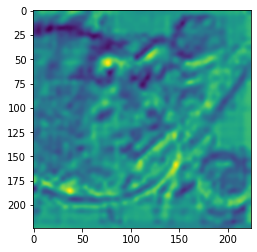

In [98]:
plt.imshow((output_images[2]*255).astype(np.uint32))

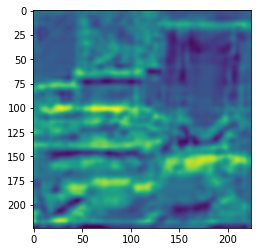

In [99]:
plt.imshow((output_images[3]*255).astype(np.uint32))

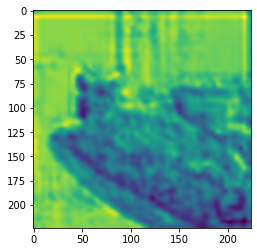

In [100]:
plt.imshow((output_images[4]*255).astype(np.uint32))

1d) Guided GradCAM

In [101]:
for module in res_model.modules():
    module.register_backward_hook(relu_hook_function)

In [102]:
output_images = []
for img in input_images:
  output_images.append(CAM(img, 11))

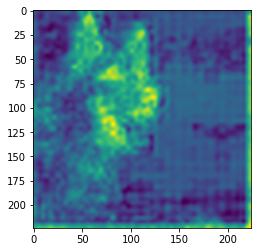

In [103]:
plt.imshow((output_images[0]*255).astype(np.uint32))

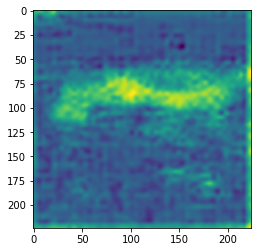

In [104]:
plt.imshow((output_images[1]*255).astype(np.uint32))

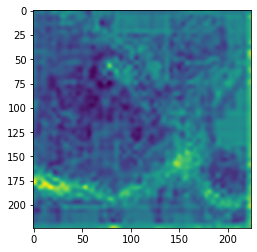

In [105]:
plt.imshow((output_images[2]*255).astype(np.uint32))

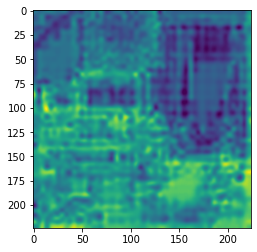

In [106]:
plt.imshow((output_images[3]*255).astype(np.uint32))

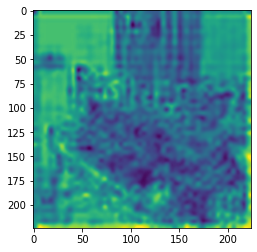

In [107]:
plt.imshow((output_images[4]*255).astype(np.uint32))

2nd Question

In [108]:
def f(x, y):
  return 10*(x**2) + y**2
def grad(x):
  return np.array([20*x[0], 2*x[1]])

# x_init = np.array([np.random.uniform(-2, 2), np.random.uniform(-2, 2)])
# x_init = np.array([2, 2])
x_init = [1.9, 1.9]


2a) vanilla sgd

[1.9, 1.9]


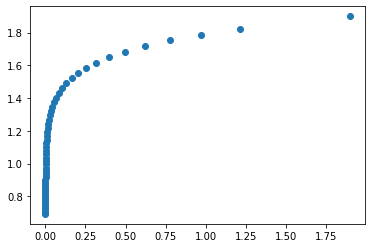

In [109]:
x = x_init
print(x)
sgd_path = []
learning_rate = 0.01
for i in range(50):
  sgd_path.append(x)
  # print(grad(x))
  x -= learning_rate*grad(x)
  # print(x)
  x = np.clip(x, -2, 2)
sgd_path = np.array(sgd_path)
# print(sgd_path)
plt.scatter(sgd_path[:, 0], sgd_path[:, 1])
# print(sgd_path)

2b) sgd+momentum

[[ 1.90000000e+00  1.90000000e+00]
 [ 8.74000000e-01  1.79056000e+00]
 [ 1.17800000e-01  1.69045280e+00]
 [-5.86340000e-01  1.56654726e+00]
 [-1.10279800e+00  1.42370134e+00]
 [-1.34705060e+00  1.26666597e+00]
 [-1.29746782e+00  1.10000083e+00]
 [-9.93349754e-01  9.28002183e-01]
 [-5.20973544e-01  7.54643357e-01]
 [ 8.35975414e-03  5.83527546e-01]
 [ 4.83087771e-01  4.17852766e-01]
 [ 8.13725433e-01  2.60388408e-01]
 [ 9.48554241e-01  1.13462718e-01]
 [ 8.80189321e-01 -2.10396575e-02]
 [ 6.42623028e-01 -1.41671002e-01]
 [ 3.00288759e-01 -2.47405792e-01]
 [-6.78698348e-02 -3.37618988e-01]
 [-3.85638602e-01 -4.12058484e-01]
 [-5.94502773e-01 -4.70812861e-01]
 [-6.63579972e-01 -5.14275543e-01]
 [-5.93033456e-01 -5.43106445e-01]
 [-4.10934901e-01 -5.58192129e-01]
 [-1.64859221e-01 -5.60605402e-01]
 [ 8.95807348e-02 -5.51565239e-01]
 [ 3.00660548e-01 -5.32397788e-01]
 [ 4.30500271e-01 -5.04499126e-01]
 [ 4.61255967e-01 -4.69300348e-01]
 [ 3.96684900e-01 -4.28235441e-01]
 [ 2.59233960e-01 -3

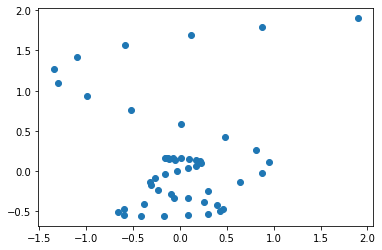

In [110]:
x = x_init
sgd_plus_mom_path = []
learning_rate = 0.01
gamma = 0.9
v = np.zeros(2)
for i in range(50):
  sgd_plus_mom_path.append(x)
  v = gamma*v + learning_rate*grad(x)
  x -= v
  x = np.clip(x, -2, 2)

sgd_plus_mom_path = np.array(sgd_plus_mom_path)
print(sgd_plus_mom_path)
plt.scatter(sgd_plus_mom_path[:, 0], sgd_plus_mom_path[:, 1])

2c) Nestorov Momentum

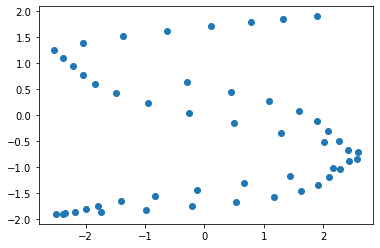

In [111]:
x = x_init
nestorov_path = []
learning_rate = 0.005

v = np.zeros(2)
gamma = 0.99
for i in range(50):
  nestorov_path.append(x)
  temp = x + gamma*v
  v = gamma*v + learning_rate*grad(temp)
  x -= v
  x = np.clip(x, -2, 2)
nestorov_path = np.array(nestorov_path)
plt.scatter(nestorov_path[:, 0], nestorov_path[:, 1])

2d) Adagrad gradient

[[1.9        1.9       ]
 [1.78143998 1.78143998]
 [1.74226467 1.74226467]
 [1.70865582 1.70865582]
 [1.6788357  1.6788357 ]
 [1.6518081  1.6518081 ]
 [1.626949   1.626949  ]
 [1.6038371  1.6038371 ]
 [1.58217219 1.58217219]
 [1.56173145 1.56173145]
 [1.54234409 1.54234409]
 [1.52387579 1.52387579]
 [1.50621869 1.50621869]
 [1.48928457 1.48928457]
 [1.47300021 1.47300021]
 [1.45730404 1.45730404]
 [1.44214369 1.44214369]
 [1.4274742  1.4274742 ]
 [1.41325658 1.41325658]
 [1.3994568  1.3994568 ]
 [1.38604494 1.38604494]
 [1.3729945  1.3729945 ]
 [1.36028191 1.36028191]
 [1.34788608 1.34788608]
 [1.33578805 1.33578805]
 [1.32397068 1.32397068]
 [1.31241847 1.31241847]
 [1.30111728 1.30111728]
 [1.29005421 1.29005421]
 [1.27921744 1.27921744]
 [1.26859613 1.26859613]
 [1.25818027 1.25818027]
 [1.24796061 1.24796061]
 [1.2379286  1.2379286 ]
 [1.22807629 1.22807629]
 [1.21839631 1.21839631]
 [1.20888174 1.20888174]
 [1.19952617 1.19952617]
 [1.19032358 1.19032358]
 [1.18126832 1.18126832]


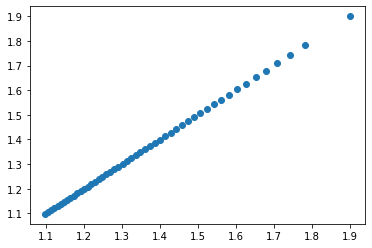

In [112]:
x = x_init
adagrad_path = []
learning_rate = 0.07
eps = 1e-8
alpha = np.zeros(2)

for i in range(50):
  adagrad_path.append(x)
  gradient = grad(x)
  alpha += gradient**2
  temp = learning_rate*((np.sqrt(alpha + eps))**(-1))
  x -= temp*gradient
  x = np.clip(x, -2, 2)
adagrad_path = np.array(adagrad_path)
print(adagrad_path)
plt.scatter(adagrad_path[:, 0], adagrad_path[:, 1])

2e) RMSprop

[[1.9        1.9       ]
 [1.7310436  1.73104406]
 [1.67558385 1.67558438]
 [1.62810075 1.62810132]
 [1.58603338 1.58603397]
 [1.54795017 1.54795079]
 [1.51295611 1.51295674]
 [1.4804479  1.48044855]
 [1.44999628 1.44999694]
 [1.42128301 1.42128368]
 [1.3940645  1.39406518]
 [1.3681494  1.36815009]
 [1.3433842  1.34338489]
 [1.31964348 1.31964418]
 [1.29682329 1.29682399]
 [1.27483628 1.27483699]
 [1.25360826 1.25360897]
 [1.23307556 1.23307627]
 [1.21318308 1.2131838 ]
 [1.19388276 1.19388347]
 [1.17513236 1.17513307]
 [1.15689455 1.15689527]
 [1.13913616 1.13913688]
 [1.12182752 1.12182824]
 [1.104942   1.10494272]
 [1.08845557 1.0884563 ]
 [1.07234649 1.07234722]
 [1.05659499 1.05659572]
 [1.04118304 1.04118377]
 [1.02609414 1.02609487]
 [1.01131316 1.01131388]
 [0.99682616 0.99682689]
 [0.9826203  0.98262103]
 [0.9686837  0.96868442]
 [0.95500532 0.95500605]
 [0.94157495 0.94157567]
 [0.92838304 0.92838377]
 [0.91542073 0.91542145]
 [0.9026797  0.90268042]
 [0.89015218 0.8901529 ]


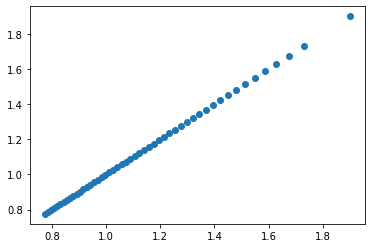

In [113]:
x = x_init
rmsprop_path = []
learning_rate = 0.01
v = np.zeros(2)
rho = 0.99
eps = 1e-6

for i in range(50):
  rmsprop_path.append(x)
  gradient = grad(x)
  v = rho*v + (1 - rho)*(gradient**2)
  temp = learning_rate*((np.sqrt(v + eps))**(-1))
  x -= temp*gradient
  x = np.clip(x, -2, 2)


rmsprop_path = np.array(rmsprop_path)
print(rmsprop_path)
plt.scatter(rmsprop_path[:, 0], rmsprop_path[:, 1])

Creating animation to view the convergence

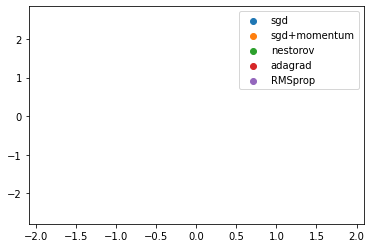

In [114]:
from matplotlib.animation import FuncAnimation
from IPython import display

fig, ax = plt.subplots()

def gif(i):
  ax.clear()
  ax.scatter(sgd_path[:i, 1], sgd_path[:i, 0], label="sgd")
  ax.scatter(sgd_plus_mom_path[:i, 1], sgd_plus_mom_path[:i, 0], label="sgd+momentum")
  ax.scatter(nestorov_path[:i, 1], nestorov_path[:i, 0], label="nestorov")
  ax.scatter(adagrad_path[:i, 1], adagrad_path[:i, 0], label="adagrad")
  ax.scatter(rmsprop_path[:i, 1], rmsprop_path[:i, 0], label="RMSprop")
  ax.legend()


animation = FuncAnimation(fig, gif, frames=50, interval=200)
animation.save('scatter_plot.gif', writer='imagemagick')